# BEAT AML ML project part 1- Defining the question, Cleaning the Data and Exploratory data analysis

**Purpose:** The goal here is to do my first ever machine learning project tackling a problem that I really care about. Hopefully this will result in a tool that will actually be useful for predicting patient response to AML treatment.

**Background:** Acute Myeloid Leukemia (AML) is a devastating type of cancer that I study in my day job as a graduate student at the University of Pittsburgh. AML treatment has remained mostly the same for the majority of patients for nearly 50 years. One of the reasons treatment has not advanced is because AML patients are so diverse that it is very difficult to know which patients are likely to respond to new potential treatments. Recently Tyner et al. published a seminal study in which they tested 122 potential therapies against 363 well-characterized patient biopsies. Those findings were published in Nature and can be found [here](https://www.nature.com/articles/s41586-018-0623-z). If you want to follow along with this notebook you can download the data by going to the 'Supplementary information' section and clicking "Supplementary Tables” link. Alternatively, [this link](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-018-0623-z/MediaObjects/41586_2018_623_MOESM3_ESM.xlsx) will direct you to the download page. Although, the dataset is somewhat small for a machine learning project, I do think this is a unique opportunity to understand which features are predictive of sensitivity to specific drug candidates.

**Main Question: Which features of the tumor are predictive of response to certain drug candidates? **

**Plan of Attack:** I will go through a somewhat standard machine learning workflow since this is my first project, but I will likely do more exploratory data analysis than most machine learning project walkthroughs I have seen online. Here are the general steps:

1. Obtain the data, clean and format as necessary
2. Exploratory data analysis
3. Feature engineering and selection
4. Establish a baseline and compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model to optimize it for the problem
6. Evaluate the best model on the testing set
7. Interpret the model results to the extent possible
8. Draw conclusions and write a well-documented report

My goal is to go throught the first three steps in this first notebook. The publication by Tyner et al. is a very comprehensive exploratory data analysis. They compare how each mutation effects drug sensitivity and which gene expression patterns are correlated with sensitivity to which drugs. Because of this, my exploratory data analysis will be quite light and I will jump into Feature engineering and setting up the machine learning model. 

**Defining the Question:** Ideally we can make a machine learning model to predict the response to several different drugs and then have a quick script to sort all the predicted drug responses and return the best responses. This could be a regression problem, since drug response is a continuous variable, but we will opt for classification since drug response is bimodal for the majority of drugs tested in this dataset. This is also a supervised problem since the measured drug responses are provided. We want to make an accurate model and interpretable model. Interpretability is very important because we would like to be able to report which features have the most influence on drug response. This is the information that will be useful to a clinician when deciding which treatment option to pursue. Another long-term goal is to make the multiple machine learning models into a web application that a clinician would be able to plug in all the information related to a given tumor as a GUI so we can control the format of all the data. The app can then calculate and return a list of the most promising treatment options.

**Notes about the notebook:** I have tried **bold** whenever there is a point at which I think there is an opportunity to improve the model performance. In general I tried to improve performance as much as possible, unless it required too much work. My goal after all is to use the same dataset to gain predictive power for predicting response to 112 potential therapies and what I may do may improve performace for one target while reducing performance for another. A more realistic goal is to make a reasonably good classifier for the drugs in this dataset as that can predict whether or not a patient will respond to the treatment. 

## Imports
These are some of the standard imports for data science projects. Pandas and numpy will help us with data cleaning and manipulation, matplotlib and seaborn will allow us to do some exploratory data analysis.

In [1]:
#standard package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 24
import seaborn as sns
sns.set(font_scale = 2)

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

Next I want to increase the maximum number of columns pandas dataframes will display.

In [2]:
pd.set_option('display.max_columns', 1000)

## Loading the Data

The data comes as an xslx file. There is a lot of tabs, but most of them contain information that will not help us. The tabs that we need to extract are:

1. **Table s5 Clinical Summary** - This contains clinical information such as the sex, and ethnicity of the patient. It also contains information about whether or not this sample a primary tumor or a relapse, and previous treatments the patient has recieved.
2. **Table s16 All Variants** - This contains the mutations found in each tumor relative to a pre-defined 'normal' reference genome.
3. **Table s9 Gene counts CPM** - This table contains the gene expression data for the tumor.
4. **Table s10 Drug responses** - This contains our labels. This has the measured drug potency against each tumor.



In [3]:
#The excel file is quite large so depending on your computer this step may take some time.

#Note that 'table' is misspelled as 'tabe' here because that is how it it in the excel file
Clinical_Summary = pd.read_excel('All_Data.xlsx', sheet_name='Tabe S5-Clinical Summary') 

Gene_Counts_CPM = pd.read_excel('All_Data.xlsx', sheet_name='Table S9-Gene Counts CPM')

Drug_Responses = pd.read_excel('All_Data.xlsx', sheet_name='Table S10-Drug Responses')

All_Variants = pd.read_excel('All_Data.xlsx', sheet_name='Table S16-All Variants')

## Cleaning the Data -Clinical Summary

Lets first take a look at the Clinical_Summary dataset.

In [4]:
Clinical_Summary.shape

(672, 159)

In [5]:
Clinical_Summary.head()

LabId  PatientId consensus_sex inferred_sex inferred_ethnicity  \
0  09-00705        163          Male         Male              White   
1  10-00136        174          Male         Male              White   
2  10-00172        175        Female         Male              White   
3  10-00507         45        Female       Female              White   
4  10-00542        174          Male         Male              White   

   centerID CEBPA_Biallelic  ageAtDiagnosis  isRelapse  isDenovo  \
0         1               n            73.0      False      True   
1         1               n            69.0      False      True   
2         1               n            59.0      False      True   
3         1               n            70.0      False      True   
4         1               n            69.0       True     False   

   isTransformed finalFusion  specificDxAtAcquisition_MDSMPN  \
0          False        None                           False   
1          False        None                           False   
2          False        None                           False   
3          False        None                           False   
4          False        None                           False   

   nonAML_MDSMPN_specificDxAtAcquisition priorMalignancyNonMyeloid  \
0                                  False                         n   
1                                  False                         n   
2                                  False                         n   
3                                  False                         n   
4                                  False                         n   

  priorMalignancyType cumulativeChemo priorMalignancyRadiationTx priorMDS  \
0                 NaN               y                          n        n   
1                 NaN               y                          n        n   
2                 NaN               y                          n        n   
3                 NaN               y                          n        n   
4                 NaN               y                          n        n   

  priorMDSMoreThanTwoMths priorMDSMPN priorMDSMPNMoreThanTwoMths priorMPN  \
0                       n           n                          n        n   
1                       n           n                          n        n   
2                       n           n                          n        n   
3                       n           n                          n        n   
4                       n           n                          n        n   

  priorMPNMoreThanTwoMths                                      dxAtInclusion  \
0                       n  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
1                       n  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
2                       n  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
3                       n  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
4                       n  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   

            specificDxAtInclusion                  ELN2017          ELN2008  \
0           AML with mutated NPM1  FavorableOrIntermediate   Intermediate-I   
1  Acute myelomonocytic leukaemia                  Adverse  Intermediate-II   
2  Acute myelomonocytic leukaemia    IntermediateOrAdverse  Intermediate-II   
3           AML with mutated NPM1  FavorableOrIntermediate   Intermediate-I   
4  Acute myelomonocytic leukaemia                  Adverse  Intermediate-II   

                             dxAtSpecimenAcquisition  \
0  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
1  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
2  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
3  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
4  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   

          specificDxAtAcquisition  ageAtSpecimenAcquisition  \
0           AML with mutated NPM1                      73.0   
1  Acute myel

We can see right away that the data is not clean and we will have many issues to tackle. We will need to remove some columns, One hot encode many categorical variables. And normalize many numerical variables. Further there are 159 columns and it is not totally obvious what many of them mean. Some definitions are easy to infer, but many are not. I read about AML and AML treatment everyday and I could not tell you what every single column meant. Understanding the columns is ideal because we want to be able to interpret the model results, so we will need to understand the columns eventually. 

First lets remove the redundant and unecessary columns: 
- PatientID is redudant and less descriptive than LabId. 
- Interestingly consensus_sex and inferred_sex don't match. I assumed that consensus_sex was the sex determined by karyotype, therefore I kept that column.
- centerID should not matter in determining the Drug responsiveness, although it would be interesting if one drug was effective at one center, but not another. That is a topic for a different project however.
- specificDxAtAcquisition_MDSMPN and nonAML_MDSMPN_specificDxAtAcquisition are unclear in what they mean, so they were dropped.
- dxAtInclusion, specificDxAtInclusion and dxAtSpecimenAcquisition are redudent and less descriptive than specificDxAtAcquisition
- ELN2008 is an outdated methos of catorgorizing a patients prognosis. We will remove and use ELN2017 only
- timeOfSampleCollectionRelativeToInclusion should have no effect on any of the data, especially drug sensitivity
- specimenGroups is a column that is redundant with other columns
- specimenType should be irrelevant to drug sensitivity, but I am curious about this so I left this feature in.
- rnaSeq, exomeSeq, totalDrug, rnaSeqAnalysis, analysisExomeSeq, analysisDrug are all irrelevant to the tumor drug sensitivity
- cumulativeTreatmentStageCount is redudant
- vitalStatus, overallSurvival, causeOfDeath, any_different_labs, any_different_labs_also_beataml, different_lab_ids, different_id_karyotype_interval are all deleted because none of that information would be known at the time Therapy is being administered. 
- any_different_cgs, any_different_cgs_also_beataml, different_cgs_lab_ids were unclear to me. I am fairly certain these are some type of administrative detail so it would not make sense to include them in the analysis.
- Surface.Antigens.(Immunohistochemical.Stains) was actually a very interesting column to me. This basically shows which immune markers are expressed on the cell surface of the tumor cells. Unfortunately I think the data included in this column was not standardized and I found over one thousand unique entires in just 672 samples. Therefore I decided to skip this column.
- Flt3-ITD and NPM1 are the last columns I kept. All the other columns are mutation info that we should be able to easily pull from the All_variants dataset.

This should significantly reduce the size of our dataset.

In [6]:
Clinical_Summary_edited = Clinical_Summary.drop(['PatientId', 'inferred_sex', 'centerID', 'specificDxAtAcquisition_MDSMPN',
                                                'nonAML_MDSMPN_specificDxAtAcquisition', 'dxAtInclusion', 'specificDxAtInclusion',
                                                'dxAtSpecimenAcquisition', 'ELN2008', 'timeOfSampleCollectionRelativeToInclusion',
                                                'specimenGroups', 'rnaSeq', 'exomeSeq', 'totalDrug', 'rnaSeqAnalysis', 
                                                 'analysisExomeSeq', 'analysisDrug', 'cumulativeTreatmentStageCount', 'vitalStatus',
                                                 'overallSurvival', 'causeOfDeath', 'any_different_labs', 
                                                 'any_different_labs_also_beataml', 'different_lab_ids', 
                                                 'different_id_karyotype_interval', 'any_different_cgs', 'any_different_cgs_also_beataml',
                                                'different_cgs_lab_ids', 'Surface.Antigens.(Immunohistochemical.Stains)'], 
                                                axis=1)

Clinical_Summary_edited = Clinical_Summary_edited.loc[: , :'NPM1']

Clinical_Summary_edited.shape

(672, 60)

This reduced the number of columns in the dataset dramatically!

Now lets take a look at the missing values in the dataset.

In [7]:
Clinical_Summary_edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 60 columns):
LabId                              672 non-null object
consensus_sex                      672 non-null object
inferred_ethnicity                 670 non-null object
CEBPA_Biallelic                    672 non-null object
ageAtDiagnosis                     666 non-null float64
isRelapse                          672 non-null bool
isDenovo                           672 non-null bool
isTransformed                      672 non-null bool
finalFusion                        672 non-null object
priorMalignancyNonMyeloid          672 non-null object
priorMalignancyType                96 non-null object
cumulativeChemo                    672 non-null object
priorMalignancyRadiationTx         672 non-null object
priorMDS                           672 non-null object
priorMDSMoreThanTwoMths            672 non-null object
priorMDSMPN                        672 non-null object
priorMDSMPNMoreThanTw

There are a couple issues here. 

1. We clearly have some missing values, see ageAtDiagnosis for example. Some of these can be safely inferred to be zero (i.e. %.Basophiles.in.PB), but some of them can't (i.e. ageAtDiagnosis).
2. Many of our data types are Objects or Booleen, not numbers. 

Lets start by removing columns where there is too much missing data to be useful for a machine learning model. The columns I Remove here are as follows: 

1.  ageAtDiagnosis                     
2.  responseDurationToInductionTx     
3.  mostRecentTreatmentDuration       
4.  %.Basophils.in.PB                
5.  %.Blasts.in.BM                   
6.  %.Blasts.in.PB                   
7.  %.Eosinophils.in.PB              
8.  %.Immature.Granulocytes.in.PB    
9.  %.Lymphocytes.in.PB              
10. %.Monocytes.in.PB                
11. %.Neutrophils.in.PB              
12. %.Nucleated.RBCs.in.PB           
13. ALT                              
14. AST                              
15. Albumin                          
16. Creatinine                       
17. Hematocrit                       
18. LDH                              
19. MCV                              
20. Platelet.Count                   
21. Total.Protein                    
22. WBC.Count                        
23. Hemoglobin

The pattern here is that all these features (except # 1-3) are clinical tests done with the sample. Unfortunatelly it seems that these tests were not done on large portions of the cohort.

An alternative strategy to removing the columns with a lot of missing data is to use and imputer to fill in the missing values with a certain pattern, for example filling in the missing values with the median of the column. I chose to remove columns instead because I do not thing it is reasonable to assume that any of these variable are normally distributed and thus it may be totally incorrect to assume that the median would be a good representation. **More effort for determining the values of these columns may significantly improve the model more than simply removing them.**

In [8]:
Clinical_Summary_edited = Clinical_Summary_edited.drop(['ageAtDiagnosis','responseDurationToInductionTx',
                                                        'mostRecentTreatmentDuration','%.Basophils.in.PB','%.Blasts.in.BM',
                                                        '%.Blasts.in.PB','%.Eosinophils.in.PB','%.Immature.Granulocytes.in.PB',
                                                        '%.Lymphocytes.in.PB','%.Monocytes.in.PB','%.Neutrophils.in.PB',
                                                        '%.Nucleated.RBCs.in.PB','ALT','AST','Albumin','Creatinine','Hematocrit',
                                                        'LDH','MCV','Platelet.Count','Total.Protein','WBC.Count','Hemoglobin'],
                                                       axis=1)


Clinical_Summary_edited.shape

(672, 37)

Lets now set the LabId column as the index. This variable has nothing to do with Clinical info about the tumor, but we can use it to later join our multiple datasets into one.

In [9]:
Clinical_Summary_edited.set_index('LabId', inplace=True)

Clinical_Summary_edited.head()

consensus_sex inferred_ethnicity CEBPA_Biallelic  isRelapse  \
LabId                                                                  
09-00705          Male              White               n      False   
10-00136          Male              White               n      False   
10-00172        Female              White               n      False   
10-00507        Female              White               n      False   
10-00542          Male              White               n       True   

          isDenovo  isTransformed finalFusion priorMalignancyNonMyeloid  \
LabId                                                                     
09-00705      True          False        None                         n   
10-00136      True          False        None                         n   
10-00172      True          False        None                         n   
10-00507      True          False        None                         n   
10-00542     False          False        None                         n   

         priorMalignancyType cumulativeChemo priorMalignancyRadiationTx  \
LabId                                                                     
09-00705                 NaN               y                          n   
10-00136                 NaN               y                          n   
10-00172                 NaN               y                          n   
10-00507                 NaN               y                          n   
10-00542                 NaN               y                          n   

         priorMDS priorMDSMoreThanTwoMths priorMDSMPN  \
LabId                                                   
09-00705        n                       n           n   
10-00136        n                       n           n   
10-00172        n                       n           n   
10-00507        n                       n           n   
10-00542        n                       n           n   

         priorMDSMPNMoreThanTwoMths priorMPN priorMPNMoreThanTwoMths  \
LabId                                                                  
09-00705                          n        n                       n   
10-00136                          n        n                       n   
10-00172                          n        n                       n   
10-00507                          n        n                       n   
10-00542                          n        n                       n   

                          ELN2017         specificDxAtAcquisition  \
LabId                                                               
09-00705  FavorableOrIntermediate           AML with mutated NPM1   
10-00136                  Adverse  Acute myelomonocytic leukaemia   
10-00172    IntermediateOrAdverse  Acute myelomonocytic leukaemia   
10-00507  FavorableOrIntermediate           AML with mutated NPM1   
10-00542                  Adverse  Acute myelomonocytic leukaemia   

          ageAtSpecimenAcquisition          specimenType  \
LabId                                                      
09-00705                      73.0  Bone Marrow Aspirate   
10-00136                      69.0         Leukapheresis   
10-00172                      59.0         Leukapheresis   
10-00507                      70.0         Leukapheresis   
10-00542                      69.0      Peripheral Blood   

          cumulativeTreatmentTypeCount  \
LabId                                    
09-00705                             2   
10-00136                             2   
10-00172                             3   
10-00507                             2   
10-00542                             2   

                                   cumulativeTreatmentTypes  \
LabId                                                         
09-00705  Standard Chemotherapy|Targeted Therapy - Kinas...   
10-00136  Standard Chemotherapy|Targeted Therapy - Kinas...   
10-00172  Standard Chemotherapy|Bone Marrow Transplant|T...   
10-00507                  Standa

Next lets address the second major issue in thie clinical dataset: Many of the features are Booleens or object data types. Luckily columns with only two possibilities in each cell are quite each to convert into numeric dtype.

In [10]:
#Yes/no columns
Y_N_list = ['CEBPA_Biallelic','priorMalignancyNonMyeloid','cumulativeChemo','priorMalignancyRadiationTx', 'priorMDS', 
            'priorMDSMoreThanTwoMths', 'priorMDSMPN','priorMDSMPNMoreThanTwoMths','priorMPN', 'priorMPNMoreThanTwoMths']

#Convert these columns using the .replace function
#Note that for prioirMDSMPNMoreThanTwoMths one value was simply 'u' so I replaced it with np.nan
for i in Y_N_list: Clinical_Summary_edited[i].replace(('y', 'n', 'u'), (1, 0, np.nan), inplace=True)

#Positive/negative columns
P_N_list = ['FLT3-ITD', 'NPM1']
for i in P_N_list: Clinical_Summary_edited[i].replace(('positive', 'negative'), (1, 0), inplace=True)
    
#True False Columns already have a numeric value (1 for true, 0 for False) so they are even easier to convert to numeric
T_F_list = ['isRelapse','isDenovo', 'isTransformed' ]
for i in T_F_list: Clinical_Summary_edited[i] = Clinical_Summary_edited[i].astype(int)

Clinical_Summary_edited.head()

consensus_sex inferred_ethnicity  CEBPA_Biallelic  isRelapse  \
LabId                                                                   
09-00705          Male              White                0          0   
10-00136          Male              White                0          0   
10-00172        Female              White                0          0   
10-00507        Female              White                0          0   
10-00542          Male              White                0          1   

          isDenovo  isTransformed finalFusion  priorMalignancyNonMyeloid  \
LabId                                                                      
09-00705         1              0        None                          0   
10-00136         1              0        None                          0   
10-00172         1              0        None                          0   
10-00507         1              0        None                          0   
10-00542         0              0        None                          0   

         priorMalignancyType  cumulativeChemo  priorMalignancyRadiationTx  \
LabId                                                                       
09-00705                 NaN                1                           0   
10-00136                 NaN                1                           0   
10-00172                 NaN                1                           0   
10-00507                 NaN                1                           0   
10-00542                 NaN                1                           0   

          priorMDS  priorMDSMoreThanTwoMths  priorMDSMPN  \
LabId                                                      
09-00705         0                        0            0   
10-00136         0                        0            0   
10-00172         0                        0            0   
10-00507         0                        0            0   
10-00542         0                        0            0   

          priorMDSMPNMoreThanTwoMths  priorMPN  priorMPNMoreThanTwoMths  \
LabId                                                                     
09-00705                         0.0         0                        0   
10-00136                         0.0         0                        0   
10-00172                         0.0         0                        0   
10-00507                         0.0         0                        0   
10-00542                         0.0         0                        0   

                          ELN2017         specificDxAtAcquisition  \
LabId                                                               
09-00705  FavorableOrIntermediate           AML with mutated NPM1   
10-00136                  Adverse  Acute myelomonocytic leukaemia   
10-00172    IntermediateOrAdverse  Acute myelomonocytic leukaemia   
10-00507  FavorableOrIntermediate           AML with mutated NPM1   
10-00542                  Adverse  Acute myelomonocytic leukaemia   

          ageAtSpecimenAcquisition          specimenType  \
LabId                                                      
09-00705                      73.0  Bone Marrow Aspirate   
10-00136                      69.0         Leukapheresis   
10-00172                      59.0         Leukapheresis   
10-00507                      70.0         Leukapheresis   
10-00542                      69.0      Peripheral Blood   

          cumulativeTreatmentTypeCount  \
LabId                                    
09-00705                             2   
10-00136                             2   
10-00172                             3   
10-00507                             2   
10-00542                             2   

                                   cumulativeTreatmentTypes  \
LabId                                                         
09-00705  Standard Chemotherapy|Targeted Therapy - Kinas...   
10-00136  Standard Chemotherapy|Targeted Therapy - Kinas...   
10-00172  Standard Chemot

Now lets One-hot encode all of the categorical variables. One-hot encoding converts a column such as Consensus_sex into multiple columns (i.e. Male and Female) and leave only values of 0 and 1 in each cell.

Note that the columns 'priorMalignancyType', 'cumulativeTreatmentTypes', 'cumulativeTreatmentRegimens', 'cumulativeTreatmentStages' all have multipe pieces of information within each cell so we will have to seperate these out before we one-hot encode them.

In [11]:
One_hot_encode_list = ['consensus_sex', 'inferred_ethnicity', 'finalFusion', 'ELN2017', 'specificDxAtAcquisition', 
                       'specimenType', 'responseToInductionTx', 'typeInductionTx', 'mostRecentTreatmentType', 
                       'currentRegimen', 'currentStage', 'FAB/Blast.Morphology', 'Karyotype', 'Other.Cytogenetics']

Clinical_Summary_edited = pd.get_dummies(Clinical_Summary_edited, columns= One_hot_encode_list)

Clinical_Summary_edited.head()

CEBPA_Biallelic  isRelapse  isDenovo  isTransformed  \
LabId                                                           
09-00705                0          0         1              0   
10-00136                0          0         1              0   
10-00172                0          0         1              0   
10-00507                0          0         1              0   
10-00542                0          1         0              0   

          priorMalignancyNonMyeloid priorMalignancyType  cumulativeChemo  \
LabId                                                                      
09-00705                          0                 NaN                1   
10-00136                          0                 NaN                1   
10-00172                          0                 NaN                1   
10-00507                          0                 NaN                1   
10-00542                          0                 NaN                1   

          priorMalignancyRadiationTx  priorMDS  priorMDSMoreThanTwoMths  \
LabId                                                                     
09-00705                           0         0                        0   
10-00136                           0         0                        0   
10-00172                           0         0                        0   
10-00507                           0         0                        0   
10-00542                           0         0                        0   

          priorMDSMPN  priorMDSMPNMoreThanTwoMths  priorMPN  \
LabId                                                         
09-00705            0                         0.0         0   
10-00136            0                         0.0         0   
10-00172            0                         0.0         0   
10-00507            0                         0.0         0   
10-00542            0                         0.0         0   

          priorMPNMoreThanTwoMths  ageAtSpecimenAcquisition  \
LabId                                                         
09-00705                        0                      73.0   
10-00136                        0                      69.0   
10-00172                        0                      59.0   
10-00507                        0                      70.0   
10-00542                        0                      69.0   

          cumulativeTreatmentTypeCount  \
LabId                                    
09-00705                             2   
10-00136                             2   
10-00172                             3   
10-00507                             2   
10-00542                             2   

                                   cumulativeTreatmentTypes  \
LabId                                                         
09-00705  Standard Chemotherapy|Targeted Therapy - Kinas...   
10-00136  Standard Chemotherapy|Targeted Therapy - Kinas...   
10-00172  Standard Chemotherapy|Bone Marrow Transplant|T...   
10-00507                  Standard Chemotherapy|Intrathecal   
10-00542  Standard Chemotherapy|Targeted Therapy - Kinas...   

          cumulativeTreatmentRegimenCount  \
LabId                                       
09-00705                                3   
10-00136                                4   
10-00172                                5   
10-00507                                3   
10-00542                                4   

                                cumulativeTreatmentRegimens  \
LabId                                                         
09-00705   7+3 (Cytarabine, Idarubicin)|MiDAC|AC220 (Ambit)   
10-00136  7+3 (Cytarabine, Idarubicin)|MiDAC|Hydroxyurea...   
10-00172  7+3 (Cytarabine, Idarubicin)|HiDAC|FLAG-IDA (C...   
10-00507  7+3 (Cytarabine, Idarubicin)|MiDAC|Cytarabine,...   
10-00542  7+3 (Cytarabine, Idarubicin)|MiDAC|Hydroxyurea...   

                                  cumulativeTreatmentStages  FLT3-ITD  NPM1  \
LabId                                

In [12]:
Clinical_Summary_edited.shape

(672, 838)

The dataframe has significantly more columns now. This is because some columns had a lot of different possiblities. For example currentRegimen. It is extremely surprising how different the treatment regimens are between these many patients! Karyotype and Other.Cytogenetics also had so many different possibilties. 

Lets take a quick check on how many each currentRegimen, Karyotype and Other.Cytogenetics columns there are.

In [13]:
CurReg_cols = [col for col in Clinical_Summary_edited.columns if 'currentRegimen' in col]
Kar_cols = [col for col in Clinical_Summary_edited.columns if 'Karyotype' in col]
Cyto_cols = [col for col in Clinical_Summary_edited.columns if 'Other.Cytogenetics' in col]

print('There are ', len(CurReg_cols), 'currentRegimen columns, ', len(Kar_cols), 'Karyotype columns and ', len(Cyto_cols), 
      'Other.Cytogenetics columns')

There are  114 currentRegimen columns,  323 Karyotype columns and  267 Other.Cytogenetics columns


Base on this information I have decided to remove the currentRegimen, Karyotype and Other.Cytogenetic columns since probably there are only 2 or 3 data points in each category. This data is known to be useful so its a bit of a shame that we have to remove them, but based my exploration of the data I think the data entry was not standardized which results in way too many possibilities for each of these three variables.

In [14]:
rm_cols = CurReg_cols +Kar_cols +Cyto_cols
Clinical_Summary_edited=Clinical_Summary_edited.drop(rm_cols, axis=1)

Clinical_Summary_edited.shape

(672, 134)

For the more complex data columns that have to be one hot encoded, We can seperate out individual pieces of information into a list. A list can be one-hot encoded using the Multi Label Binarizer from Sci-Kit learn.

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [16]:
#Make a list of the columns that need to be manipulated
Complex_one_hot_encode = ['priorMalignancyType', 'cumulativeTreatmentTypes', 'cumulativeTreatmentRegimens', 
                          'cumulativeTreatmentStages']

#reformat the complex cells into lists
for i in Complex_one_hot_encode:
    Clinical_Summary_edited[i] = Clinical_Summary_edited[i].replace(np.nan,'')
    Clinical_Summary_edited[i] = Clinical_Summary_edited[i].str.split('|')

#One hot encode the columns using multilabelbinazer and merge the new data frames 
for i in Complex_one_hot_encode:
    Clinical_Summary_edited = Clinical_Summary_edited.merge(pd.DataFrame(mlb.fit_transform(Clinical_Summary_edited[i]), 
                                                                         columns= i+mlb.classes_, 
                                                                         index=Clinical_Summary_edited.index), 
                                                            left_index=True, right_index=True)

#Remove the original columns which contain the list to be one-hot encoded
for i in Complex_one_hot_encode:
    Clinical_Summary_edited.drop(i+'_x',axis =1, inplace=True)
    
    
Clinical_Summary_edited.head()

CEBPA_Biallelic  isRelapse  isDenovo  isTransformed  \
LabId                                                           
09-00705                0          0         1              0   
10-00136                0          0         1              0   
10-00172                0          0         1              0   
10-00507                0          0         1              0   
10-00542                0          1         0              0   

          priorMalignancyNonMyeloid  cumulativeChemo  \
LabId                                                  
09-00705                          0                1   
10-00136                          0                1   
10-00172                          0                1   
10-00507                          0                1   
10-00542                          0                1   

          priorMalignancyRadiationTx  priorMDS  priorMDSMoreThanTwoMths  \
LabId                                                                     
09-00705                           0         0                        0   
10-00136                           0         0                        0   
10-00172                           0         0                        0   
10-00507                           0         0                        0   
10-00542                           0         0                        0   

          priorMDSMPN  priorMDSMPNMoreThanTwoMths  priorMPN  \
LabId                                                         
09-00705            0                         0.0         0   
10-00136            0                         0.0         0   
10-00172            0                         0.0         0   
10-00507            0                         0.0         0   
10-00542            0                         0.0         0   

          priorMPNMoreThanTwoMths  ageAtSpecimenAcquisition  \
LabId                                                         
09-00705                        0                      73.0   
10-00136                        0                      69.0   
10-00172                        0                      59.0   
10-00507                        0                      70.0   
10-00542                        0                      69.0   

          cumulativeTreatmentTypeCount  cumulativeTreatmentRegimenCount  \
LabId                                                                     
09-00705                             2                                3   
10-00136                             2                                4   
10-00172                             3                                5   
10-00507                             2                                3   
10-00542                             2                                4   

          FLT3-ITD  NPM1  consensus_sex_Female  consensus_sex_Male  \
LabId                                                                
09-00705       1.0   1.0                     0                   1   
10-00136       1.0   0.0                     0                   1   
10-00172       1.0   0.0                     1                   0   
10-00507       1.0   1.0                     1                   0   
10-00542       1.0   0.0                     0                   1   

          inferred_ethnicity_AdmixedAsian  inferred_ethnicity_AdmixedBlack  \
LabId                                                                        
09-00705                                0                                0   
10-00136                                0                                0   
10-00172                                0                                0   
10-00507                                0                                0   
10-00542                                0                                0   

          inferred_ethnicity_AdmixedHispNative  \
LabId                                            
09-00705                                     0   
10-00136                             

In [17]:
Clinical_Summary_edited.shape

(672, 366)

Now we have 366 columns which is still too many. Lets take a look at how many of columns each variable generated.

In [18]:
for i in Complex_one_hot_encode:
    cols = [col for col in Clinical_Summary_edited.columns if i in col]
    print('There are ', len(cols), i, 'columns')

There are  27 priorMalignancyType columns
There are  10 cumulativeTreatmentTypes columns
There are  179 cumulativeTreatmentRegimens columns
There are  20 cumulativeTreatmentStages columns


We have far to many cumulativeTreatmentRegimens columns. We can just remove them since again it will not give us any useful info if there is only 1 or two data points in each column. The cumulativeTreatmentTypes column contains simiair information, but less detail.

In [19]:
Clinical_Summary_edited.drop([col for col in Clinical_Summary_edited.columns if 'cumulativeTreatmentRegimens' in col], 
                             axis =1, inplace=True)

Clinical_Summary_edited.shape

(672, 187)

Okay great. We're down to 187 columns. Lets double check that they are all numeric columns and no more 'object' dtypes.

In [20]:
Clinical_Summary_edited.info()

<class 'pandas.core.frame.DataFrame'>
Index: 672 entries, 09-00705 to 17-00096
Columns: 187 entries, CEBPA_Biallelic to cumulativeTreatmentStagesUnknown
dtypes: float64(4), int32(60), int64(11), uint8(112)
memory usage: 335.0+ KB


Were officially done cleaning our first dataset. I promise that was by far the most difficult one! We can now move onto cleaning the next dataset.

## Cleaning Data - All Variants

Lets clean the All Variants dataset.

In [21]:
All_Variants.head()

chrom  pos_start  pos_end ref alt     labId  tumor_only genotyper  \
0     1     887417   887417   C   A  15-00208           0    mutect   
1     1     905668   905668   C   A  16-00564           0    mutect   
2     1     914477   914477   C   T  14-00141           0    mutect   
3     1     914477   914477   C   T  14-00141           0   varscan   
4     1     914941   914941   G   A  15-00492           0    mutect   

   total_reads  allele_reads  normal_total_reads  normal_allele_reads  \
0           31             3                   9                    0   
1           49             4                  48                    1   
2           33            17                   8                    0   
3           31            17                   8                    0   
4           74            12                  46                    0   

      t_vaf     n_vaf  all_consequences chosen_consequence    impact  \
0  0.096774  0.000000  missense_variant   missense_variant  MODERATE   
1  0.081633  0.020833  missense_variant   missense_variant  MODERATE   
2  0.515152  0.000000  missense_variant   missense_variant  MODERATE   
3  0.548387  0.000000  missense_variant   missense_variant  MODERATE   
4  0.162162  0.000000  missense_variant   missense_variant  MODERATE   

     symbol     ensembl_gene canonical       refseq         biotype   exon  \
0     NOC2L  ENSG00000188976       YES  NM_015658.3  protein_coding  11/19   
1   PLEKHN1  ENSG00000187583       YES  NM_032129.2  protein_coding   3/16   
2  C1orf170  ENSG00000187642       YES          NaN  protein_coding    3/5   
3  C1orf170  ENSG00000187642       YES          NaN  protein_coding    3/5   
4  C1orf170  ENSG00000187642       YES          NaN  protein_coding    3/5   

                         hgvsc                          hgvsp cdna_position  \
0  ENST00000327044.6:c.1294G>T  ENSP00000317992.6:p.Val432Phe     1344/2790   
1   ENST00000379410.3:c.195C>A   ENSP00000368720.3:p.Asp65Glu      230/2404   
2  ENST00000433179.2:c.1651G>A  ENSP00000414022.2:p.Ala551Thr     1651/3064   
3  ENST00000433179.2:c.1651G>A  ENSP00000414022.2:p.Ala551Thr     1651/3064   
4  ENST00000433179.2:c.1187C>T  ENSP00000414022.2:p.Ala396Val     1187/3064   

  cds_position protein_position amino_acids   codons existing_variation  \
0    1294/2250          432/749         V/F  Gtc/Ttc                NaN   
1     195/1836           65/611         D/E  gaC/gaA                NaN   
2    1651/2091          551/696         A/T  Gcc/Acc                NaN   
3    1651/2091          551/696         A/T  Gcc/Acc                NaN   
4    1187/2091          396/696         A/V  gCa/gTa                NaN   

  variant_class               sift       polyphen  exac_af short_aa_change  \
0           SNV  deleterious(0.01)  benign(0.033)      NaN         p.V432F   
1           SNV    tolerated(0.11)  benign(0.122)      NaN          p.D65E   
2           SNV    tolerated(0.12)  benign(0.002)      NaN         p.A551T   
3           SNV    tolerated(0.12)  benign(0.002)      NaN         p.A551T   
4           SNV    tolerated(0.11)  benign(0.003)      NaN         p.A396V   

    validation   rna_status  inclusion  Comment  
0     not_done     not_done      False      NaN  
1     not_done  not_covered      False      NaN  
2  not_covered  not_covered       True  Include  
3  not_covered  not_covered       True  Include  
4     not_done     not_done       True  Include

In [22]:
All_Variants.shape

(18580, 40)

There are 18580 rows in this dataset. This is because each individual mutation is given a row in this dataset rather than each sample. Our goal is to convert this into a dataset where the key is LabId and each row is one sample. Each column will be a one hot encoded version of each mutation found in the whole dataset. From this we will only keep the top 100 mutations.

Let's start by removing the columns we don't need.

In [23]:
All_Variants_edited = All_Variants[['labId', 'symbol', 'chosen_consequence', 'short_aa_change']]

All_Variants_edited.head()

labId    symbol chosen_consequence short_aa_change
0  15-00208     NOC2L   missense_variant         p.V432F
1  16-00564   PLEKHN1   missense_variant          p.D65E
2  14-00141  C1orf170   missense_variant         p.A551T
3  14-00141  C1orf170   missense_variant         p.A551T
4  15-00492  C1orf170   missense_variant         p.A396V

Let's rename the labId column so it matches the Clinical info dataset. Lets also change the name of the short_aa_change and chosen_consequence columns.

In [24]:
All_Variants_edited.rename(columns={'labId':'LabId', 'short_aa_change':'AA_change', 'chosen_consequence':'consequence'}, 
                           inplace=True)

All_Variants_edited.head();

Let's make sure that not all the variants in the dataset have the consequence of missense mutation.

In [25]:
data_format = All_Variants_edited['AA_change'].str.startswith('p.', na= False)

All_Variants_edited[data_format==False].head(15)

LabId  symbol                  consequence AA_change
150   14-00488   NBPF1         splice_donor_variant       NaN
151   16-00547   MST1L         splice_donor_variant       NaN
152   16-00547   MST1L         splice_donor_variant       NaN
346   16-00820   EXTL1           frameshift_variant       NaN
1117  14-00803  TCHHL1      splice_acceptor_variant       NaN
2193  15-00294   CUZD1         splice_donor_variant       NaN
2202  14-00464  ZRANB1           frameshift_variant       NaN
3084  15-00416   FOLR3      splice_acceptor_variant       NaN
3324  16-00003     CBL             inframe_deletion       NaN
4671  16-00264    FLT3  internal_tandem_duplication       ITD
4672  15-00593    FLT3  internal_tandem_duplication       ITD
4673  14-00888    FLT3  internal_tandem_duplication       ITD
4674  13-00450    FLT3  internal_tandem_duplication       ITD
4675  15-00320    FLT3  internal_tandem_duplication       ITD
4676  16-00945    FLT3  internal_tandem_duplication       ITD

As expected we have a lot of other types of consequences for mutations. Especially a lot of Flt3-ITD mutations which we would definetly expect for AML tumors. Let's quickly check how many tumors have the FLt3-ITD mutation. According to the Tyner et al. publication Figure 1A we should expect less than 224 Flt3-ITD tumors.

In [26]:
data_format = All_Variants_edited['AA_change'].str.startswith('ITD', na= False)

len(All_Variants_edited[data_format == True])

203

203 out of 672 samples have Flt3-ITD which is less than one-third, but more than one-fourth of the tumors as we would expect!

Next, let's combine the three data columns (symbol, consequence and AA change) into one column. The text in these Data frames will become the titles of the columns of our final data set.

In [27]:
#remove the uneccesary 'p.' in front of every AA_change
All_Variants_edited['AA_change'] = All_Variants_edited['AA_change'].str[2:]

#Replace all the NaN to an empty string so that the next step works
All_Variants_edited['AA_change'].replace(np.nan, '', regex = True, inplace= True)

#Combine the thre data columns into one
All_Variants_edited['mutation'] = All_Variants_edited['symbol']+'_'+All_Variants_edited['consequence']+'_'+All_Variants_edited['AA_change']

#Drop the unecessary columns
All_Variants_edited.drop(['symbol','consequence','AA_change'], axis =1, inplace=True)

All_Variants_edited.head();

Next we can use groupby and agg to get the data into a format we want. 

In [28]:
All_Variants_edited = All_Variants_edited.groupby('LabId').agg({'mutation':'|'.join})

All_Variants_edited.head()

mutation
LabId                                                      
09-00705  CROCC_missense_variant_E933K|CROCC_missense_va...
10-00136  WT1_frameshift_variant_A82Pfs*15|FLT3_internal...
10-00172  ETV6_frameshift_variant_H308Sfs*18|FLT3_intern...
10-00507  FLT3_internal_tandem_duplication_D|CBLB_stop_g...
10-00542  WT1_frameshift_variant_A82Pfs*15|FLT3_internal...

In [29]:
All_Variants_edited.shape

(740, 1)

Note that we end up with 740 rows here. We expected 672 or less rows (one for each sample in the study). I am not sure where the extra rows are coming from, but we can remove them when we join the multiple dataframes together. 

Next lets seperate out the individual mutations per sample into a list and use the multilabelbinazer as we did for the clinical dataframe.

In [30]:
#Load the MLB
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

#Make a list of each samples mutations
All_Variants_edited['mutation'] = All_Variants_edited['mutation'].str.split('|')

#One hot encode the columns using multilabelbinazer and make the new dataframe 
All_Variants_One_hot_encoded = pd.DataFrame(mlb.fit_transform(All_Variants_edited['mutation']), columns= mlb.classes_, 
                                            index=All_Variants_edited.index)

All_Variants_One_hot_encoded.head()

A1CF_missense_variant_A384T  A1CF_missense_variant_A586S  \
LabId                                                                
09-00705                            0                            0   
10-00136                            0                            0   
10-00172                            0                            0   
10-00507                            0                            0   
10-00542                            0                            0   

          A1CF_missense_variant_Y517H  A2ML1_missense_variant_P573Q  \
LabId                                                                 
09-00705                            0                             0   
10-00136                            0                             0   
10-00172                            0                             0   
10-00507                            0                             0   
10-00542                            0                             0   

          A2M_missense_variant_A749S  A2M_missense_variant_F219L  \
LabId                                                              
09-00705                           0                           0   
10-00136                           0                           0   
10-00172                           0                           0   
10-00507                           0                           0   
10-00542                           0                           0   

          A2M_missense_variant_G956V  A4GALT_missense_variant_T345M  \
LabId                                                                 
09-00705                           0                              0   
10-00136                           0                              0   
10-00172                           0                              0   
10-00507                           0                              0   
10-00542                           0                              0   

          A4GNT_stop_gained_E328*  AADACL3_missense_variant_V67I  \
LabId                                                              
09-00705                        0                              0   
10-00136                        0                              0   
10-00172                        0                              0   
10-00507                        0                              0   
10-00542                        0                              0   

          AADACL4_missense_variant_D77E  AADAC_missense_variant_R355Q  \
LabId                                                                   
09-00705                              0                             0   
10-00136                              0                             0   
10-00172                              0                             0   
10-00507                              0                             0   
10-00542                              0                             0   

          AAK1_inframe_deletion_Q546del  AAK1_missense_variant_G132C  \
LabId                                                                  
09-00705                              0                            0   
10-00136                              0                            0   
10-00172                              0                            0   
10-00507                              0                            0   
10-00542                              0                            0   

          AAK1_missense_variant_Q456H  AAMP_missense_variant_C376F  \
LabId                                                                
09-00705                            0                            0   
10-00136                            0                            0   
10-00172                            0                            0   
10-00507                            0                            0   
10-00542                            0                            0   

          AARD_missense_variant_L118M  AARS2_missense_variant

Let's do a little bit of exploratory data analysis here. How many mutations are in each sample? And what does the distribution of total mutations look like?

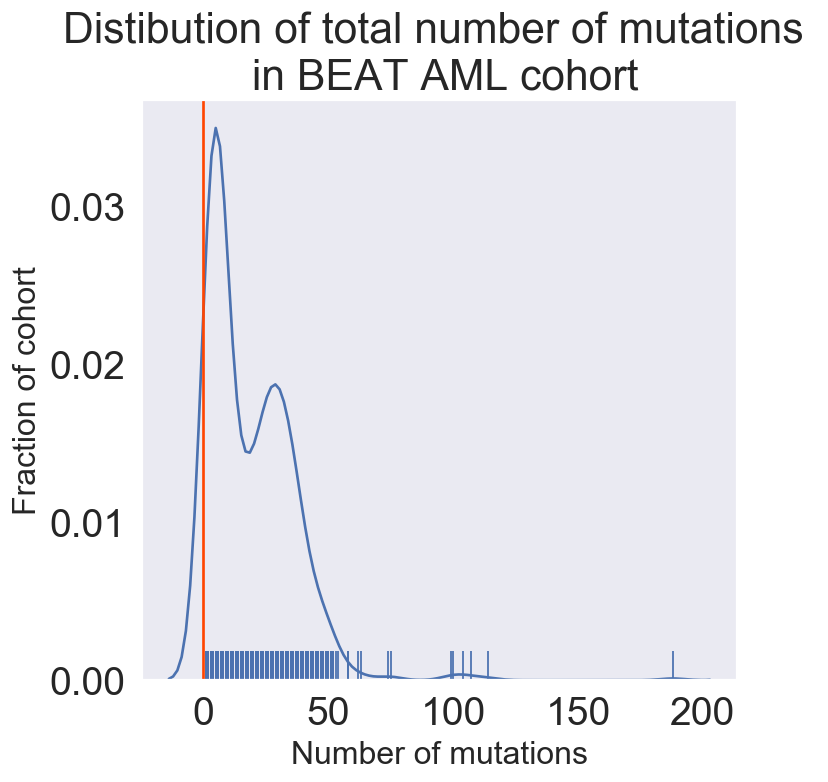

In [31]:
#Make a data frame that contains the total of mutations in each sample
Total_mutations = All_Variants_One_hot_encoded.sum(axis=1)

#set the plotting style
sns.set_style('dark')

#plot the distribution
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(Total_mutations, hist= False, rug=True)
plt.title("Distibution of total number of mutations \n in BEAT AML cohort", fontsize=24) 
plt.xlabel("Number of mutations", fontsize=18) 
plt.ylabel("Fraction of cohort", fontsize=18)
plt.axvline(x=0, color='orangered')

plt.show();

We can see there is a pretty wide bimodal distribution. Based on 'Mutational landscape and significance across 12 major cancer types', a paper published by Kandoth et al in 2013, we would expect more of a gaussian distribution, but this may be because the BEAT AML cohort included both de novo and recurrent AML and we would definitely expect recurrent AML to have more mutations. 

I included a 'rug' which is all the lines on the X-axis representing individual tumors. This is just to show that none of the samples have less than zero mutations (red line; x=0) even though the distribution line suggests this.

Now lets ask a different question. How often does each mutation occur in the dataset? Or, how often do multiple tumors have the same mutations? After all, clinically important mutations are likely to occur in multiple patients.

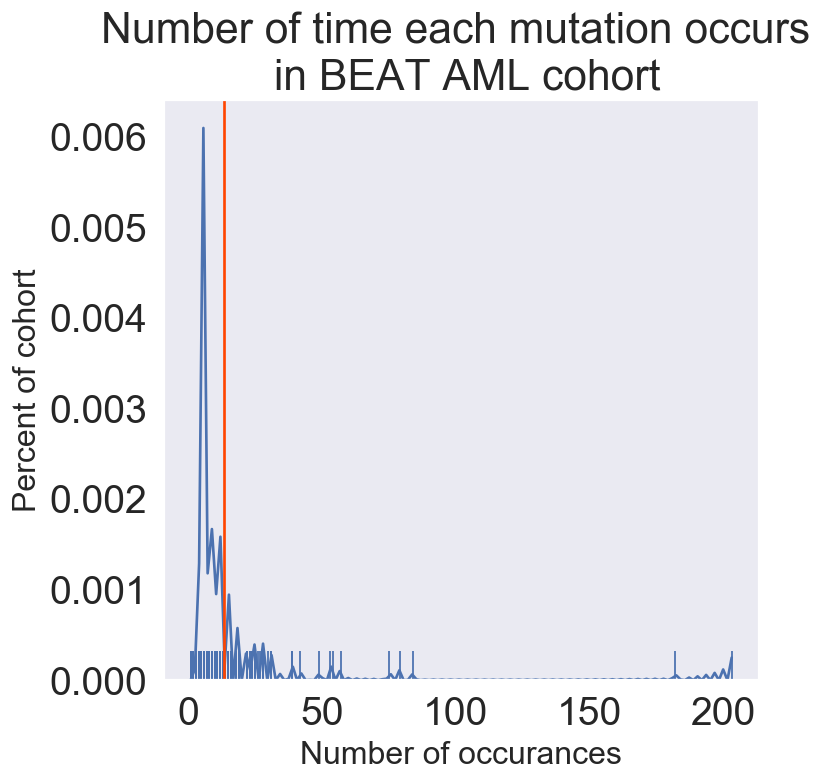

In [32]:
#Make a data frame that contains the total of sampless with each mutation, sort the table so that it is in descending order
Total_mutations = All_Variants_One_hot_encoded.sum(axis=0)
Total_mutations.sort_values(ascending=False, inplace=True)
#Total_mutations.head()

#plot the distribution
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(Total_mutations, rug = True, hist= False)
plt.title("Number of time each mutation occurs \n in BEAT AML cohort", fontsize=24) 
plt.xlabel("Number of occurances", fontsize=18) 
plt.ylabel("Fraction of cohort", fontsize=18)
plt.axvline(x=(672*0.02), color='orangered')

plt.show();

In [33]:
Total_mutations.describe()

count    9407.000000
mean        1.489742
std         3.754093
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       203.000000
dtype: float64

In [34]:
sum(All_Variants_One_hot_encoded.sum(axis=0) >= 672*0.02)

49

The All_Variants_One_hot_encoded dataframe has 9407 columns. This means there are 9407 unique mutations in the dataset! That is a lot of information. When we plot the data, we see that the vast majority of those mutations do not occur in more than two percent of the samples. When we do .decribe() on the data we see that by far the most of the mutations occur only once. Lets simplify this dataset by reducing the number of columns by keeping only mutations that appear greater than 2% of the time. This leaves us with 49 columns.

In [35]:
All_Variants_One_hot_encoded = All_Variants_One_hot_encoded.loc[:,All_Variants_One_hot_encoded.sum(axis=0) > 672*0.02]

All_Variants_One_hot_encoded.shape

(740, 49)

In [36]:
All_Variants_One_hot_encoded.head()

ANKRD30BL_missense_variant_A70G  \
LabId                                       
09-00705                                0   
10-00136                                0   
10-00172                                0   
10-00507                                0   
10-00542                                0   

          ASXL1_frameshift_variant_G646Wfs*12  BMS1_missense_variant_V791M  \
LabId                                                                        
09-00705                                    0                            0   
10-00136                                    0                            0   
10-00172                                    0                            0   
10-00507                                    0                            0   
10-00542                                    0                            0   

          CDC27_missense_variant_G265D  CDC27_missense_variant_N571I  \
LabId                                                                  
09-00705                             0                             0   
10-00136                             0                             0   
10-00172                             0                             0   
10-00507                             0                             0   
10-00542                             0                             0   

          CDC27_missense_variant_S252T  CDC27_missense_variant_V560F  \
LabId                                                                  
09-00705                             0                             0   
10-00136                             0                             0   
10-00172                             0                             0   
10-00507                             0                             0   
10-00542                             0                             0   

          CRIPAK_frameshift_variant_T17Vfs*390  CROCC_missense_variant_E933K  \
LabId                                                                          
09-00705                                     0                             1   
10-00136                                     0                             0   
10-00172                                     0                             0   
10-00507                                     0                             0   
10-00542                                     0                             0   

          DNMT3A_missense_variant_R882C  DNMT3A_missense_variant_R882H  \
LabId                                                                    
09-00705                              0                              0   
10-00136                              0                              1   
10-00172                              0                              0   
10-00507                              0                              0   
10-00542                              0                              1   

          DUX4L4_missense_variant_W370R  FCGBP_missense_variant_P3826S  \
LabId                                                                    
09-00705                              0                              0   
10-00136                              0                              0   
10-00172                              0                              0   
10-00507                              0                              0   
10-00542                              0                              0   

          FLT3_internal_tandem_duplication_D  FLT3_missense_variant_D835H  \
LabId                                                                       
09-00705                                   0                            0   
10-00136                                   1                            0   
10-00172                                   1                            0   
10-00507                                   1                            0   
10-00542                                   1                            0   

We now have a dataset that has 49 columns and is completely one-hot encoded. Now we just have one more dataframe to clean!

## Cleaning Data- Gene Expression

Now we have the easiest data frame to clean, The Gene expression data.

In [37]:
Gene_Counts_CPM.head()

Gene    Symbol    12-00023   12-00051    12-00066   12-00150  \
0  ENSG00000000003    TSPAN6    0.220678   1.659656    0.070215   1.709459   
1  ENSG00000000419      DPM1   29.791548  29.363142   23.311415  32.137834   
2  ENSG00000000457     SCYL3   19.336921  18.734961   10.532266  17.778376   
3  ENSG00000000460  C1orf112    6.868607   2.617150   11.129094  11.253940   
4  ENSG00000000938       FGR  801.392633  17.266804  906.792960  49.004499   

     12-00211     12-00258    12-00294    12-00372    12-00423   12-00426  \
0    0.000000     0.000000    0.000000    0.921085    0.419787   0.198171   
1   25.117470    29.351673   31.240770   22.940781   23.764632  21.006074   
2   37.659392    15.647852   39.189992   33.734750   17.724358  35.812243   
3   12.541923     8.190423   18.875313   11.110592   11.357582   9.229084   
4  111.834945  1004.458236  267.852800  170.631056  214.231512  63.301324   

    13-00007   13-00028    13-00034   13-00098    13-00118     13-00123  \
0   0.055838   0.000000    0.000000   0.000000    0.115955     0.000000   
1  29.063524  28.176101   34.303196  39.203413   24.089688    23.550667   
2  19.654871  23.989937   17.804722  15.450059   25.510139    15.387825   
3  20.185329  12.907338    6.758411  23.516117   12.465182     8.510197   
4  19.291926  68.186164  619.473686  11.031520  201.790997  1059.918940   

    13-00145   13-00146    13-00147   13-00149    13-00150    13-00157  \
0   0.142505   0.043003    1.115797   0.192177    1.493730    0.000000   
1  27.182900  43.905959   40.683687  29.787419   30.898090   32.614799   
2  20.983916   9.310128   18.825504  22.978866   23.650731   38.807482   
3   5.023314  10.148684    7.667530  26.383142   15.352229    8.532141   
4  73.354641   4.558307  134.553714  63.939999  226.825727  359.836183   

     13-00160    13-00163   13-00165   13-00166    13-00186    13-00195  \
0    1.388125    0.033224   0.256121   0.200768    0.089726    0.066787   
1   34.587453   31.147544  27.185436  30.574119   28.413164   28.818398   
2    8.386590   14.186668  31.722440  40.899337   24.345595   19.535067   
3   12.926916   17.608745  12.440172   7.887320   14.266399    9.550477   
4  527.314068  442.826714  98.350539  49.274236  474.739112  771.518260   

     13-00202   13-00204   13-00226    13-00232    13-00245    13-00250  \
0    0.000000   0.000000   0.030142    0.033484    0.032556    0.337616   
1   31.020682  37.945986  29.147565   33.416558   25.719532   29.822757   
2   23.444521  14.795326  18.507347   21.262038   21.877880   30.554258   
3    9.839770   8.438610  12.840603   12.757223   12.436533    8.946827   
4  740.269421  41.748912  65.468988  321.240937  578.819686  535.712372   

     13-00253     13-00255   13-00260   13-00262    13-00266    13-00270  \
0    2.583923     0.166787   0.000000   4.026828    0.813893    0.061001   
1   46.510617    25.918723  28.764510  29.242441   27.331067   28.792335   
2   22.649203    20.414747  14.837668  19.526919   23.865456   13.633659   
3    8.325975     8.339357  20.919643   2.588675   11.552036   10.248119   
4  307.008356  1011.830913  45.541359  64.397287  869.868310  378.295899   

    13-00281   13-00331    13-00338   13-00342    13-00353    13-00354  \
0   0.147040   0.352960    0.268626   0.113437    0.336000    0.088075   
1  30.216746  30.501615   27.735636  37.207344   38.051996   39.868737   
2  17.387495  18.971593    4.868847  10.708455   24.499998    9.981864   
3   7.315246   6.529757    1.947539   7.509531   13.859999    3.963387   
4  61.867132  34.266520  226.988983  58.261255  503.327954  118.490592   

    13-00365    13-00384    13-00393    13-00396    13-00406    13-00409  \
0   1.157895    0.297739    0.485506    0.000000    0.024296    0.034698   
1  69.035578   41.623926   29.874824   36.564890   37.488867   32.338116   
2  18.056903   11.552277   12.428962   17.304120   20.287235   19.742906   
3   2.440968    3.781287   12.623165    9.324658   10.811760   13.913717   
4 

In [38]:
Gene_Counts_CPM.shape

(22843, 453)

Okay. This dataset is actually almost exactly how we want it. We will end up with a dataframe that will have symbol as the columns and each of the LabId's as rows. Lets first get rid of the Gene column and add a 'exp' to each value in the Symbol column to clarify that this is expression of each gene. We will also set the index to symbol and transpose the data to get it into the format that we want.

In [39]:
#Drop the uneccesary column
Gene_Counts_CPM_edited = Gene_Counts_CPM.drop('Gene', axis=1)

#Add exp to clarify expression
Gene_Counts_CPM_edited['Symbol'] = Gene_Counts_CPM_edited['Symbol'] + 'exp'

#Set the index
Gene_Counts_CPM_edited.set_index('Symbol', inplace=True)

#Transpose the data and keep the LabId as a column. Then drop Symbol as the variable name
Gene_Counts_CPM_edited = Gene_Counts_CPM_edited.transpose().reset_index().rename(columns={'index':'LabId'})
Gene_Counts_CPM_edited.columns.name = None

#Reset the index
Gene_Counts_CPM_edited.set_index('LabId', inplace=True)

Gene_Counts_CPM_edited.head()

TSPAN6exp    DPM1exp   SCYL3exp  C1orf112exp      FGRexp    CFHexp  \
LabId                                                                          
12-00023   0.220678  29.791548  19.336921     6.868607  801.392633  4.744580   
12-00051   1.659656  29.363142  18.734961     2.617150   17.266804  1.468157   
12-00066   0.070215  23.311415  10.532266    11.129094  906.792960  4.739520   
12-00150   1.709459  32.137834  17.778376    11.253940   49.004499  8.262386   
12-00211   0.000000  25.117470  37.659392    12.541923  111.834945  2.118341   

           FUCA2exp    GCLCexp    NFYAexp   STPG1exp  NIPAL3exp   LAS1Lexp  \
LabId                                                                        
12-00023  62.948437  38.894521  65.348312   4.358393  43.942533  38.563503   
12-00051  31.341962  37.757170  19.500956   1.308575  21.160612  43.565966   
12-00066  43.849332  44.340838  57.435955   4.177799  25.207222  42.831213   
12-00150  84.589743  39.346054  32.052361  10.199774  23.020718  71.056524   
12-00211  59.078171  67.349788  77.470749   7.767250  71.250225  72.225334   

           ENPP4exp  SEMA3Fexp  ANKIB1exp  CYP51A1exp   KRIT1exp   RAD52exp  \
LabId                                                                         
12-00023  18.730056   0.055170  60.300299    1.213730  33.322398  13.157934   
12-00051   0.606413   9.957935  25.692749    1.244742  13.596411  12.000588   
12-00066  22.784801   0.245753  36.230994    2.106453  25.979588   7.442801   
12-00150  25.100560   2.877590  33.192001    3.732319  17.436485   9.629954   
12-00211  23.974238   4.404804  59.515289    3.463319  40.853716  22.898255   

             BADexp    LAP3exp      CD99exp  HS3ST1exp    AOC1exp  MAD1L1exp  \
LabId                                                                          
12-00023  14.619926  66.313778   231.463775   0.662034   0.303432  36.577400   
12-00051  20.681865  72.322695   470.480515   0.000000   0.000000  11.968672   
12-00066  12.463181  52.836866   146.117631   0.035108   3.440540  23.627382   
12-00150  21.824097  64.418124  1175.139288   7.778040  23.846957  38.348870   
12-00211   6.859389  60.255027   443.237595   0.000000   3.396070  29.017907   

            LASP1exp   SNX11exp  TMEM176Aexp     M6PRexp  KLHL13exp  \
LabId                                                                 
12-00023  514.511063  44.466643    30.370828  254.800487   4.689410   
12-00051  617.934554  26.139580     0.063833   84.291367   0.574496   
12-00066  588.156818  36.406531    31.561689  198.322561   2.597959   
12-00150  433.860764  16.325336     8.005968  197.585001  22.849772   
12-00211  318.188239  23.469871     0.033624  210.152858   7.599127   

            ICA1exp  DBNDD1exp     ALS2exp  CASP10exp    CFLARexp     TFPIexp  \
LabId                                                                           
12-00023  18.316285   1.048221   23.364297  43.473592  332.506774    6.178988   
12-00051  31.788793   2.840565   51.576997  60.417856  191.722166  116.686572   
12-00066  32.053195   0.105323   17.729314  44.972774  319.654261    3.335217   
12-00150  10.313738   3.903265   26.582092  20.598984   98.977692   65.101907   
12-00211  58.170311   0.235371  217.415741  47.780354  331.772520   61.835377   

          NDUFAF7exp     RBM5exp  MTMR7exp  SLC7A2exp     ARF5exp   SARM1exp  \
LabId                                                                          
12-00023   12.247636  143.606294  0.000000   0.027585  131.220734  19.419676   
12-00051   27.384321  215.404179  0.000000   0.000000   76.535668  21.830858   
12-00066   13.270655   83.520866  0.035108   0.315968  102.443837  16.570765   
12-00150   17.550449   85.700892  0.170946   2.678153  100.145823  15.812498   
12-00211   23.772491  203.461591  0.201747   0.638865   65.265072  41.021838   

          POLDIP2exp   PLXND1exp      AK2exp     CD38exp    FKBP4exp  \
LabId                                                                  
12-00023   69.48

In [40]:
Gene_Counts_CPM_edited.shape

(451, 22843)

Notice that the number of samples is only 451. This is because They only did mRNA sequenceing of 451 samples. Most likely because RNA sequencing is more expensive and requires more material than DNA sequencing.

Lets do some data analysis and see if we can figure out which of these 20,000+ genes are actually important and actually changing from sample to sample.

First lets find the most variable genes expressed and plot their expression. 

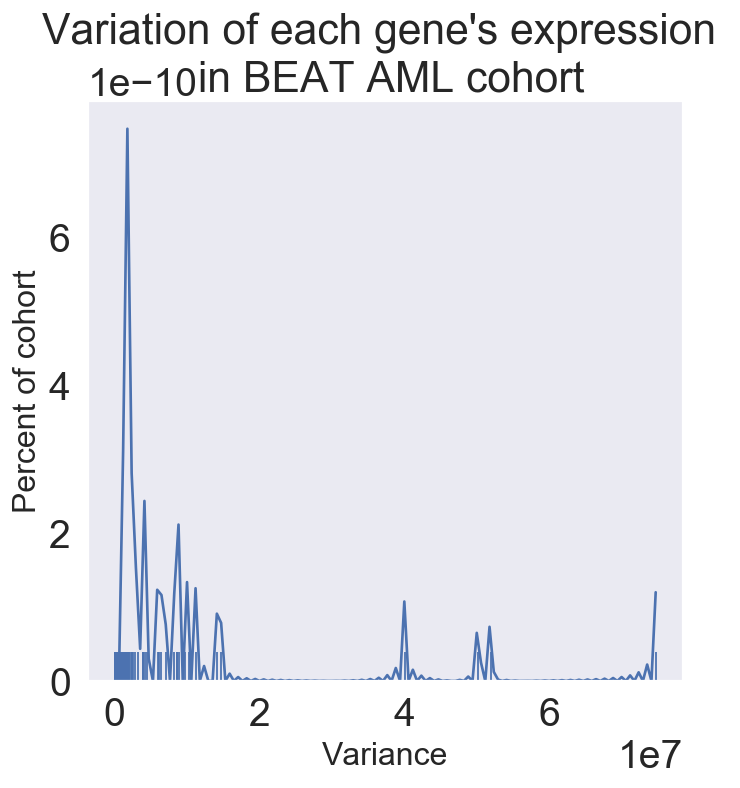

In [41]:
#Make a dataset of the variance of each gene's expression
exp_var = Gene_Counts_CPM_edited.var(axis=0,)
exp_var.sort_values(ascending=False, inplace=True)

#Plot the variance
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(exp_var, rug = True, hist= False)
plt.title("Variation of each gene's expression \n in BEAT AML cohort", fontsize=24) 
plt.xlabel("Variance", fontsize=18) 
plt.ylabel("Percent of cohort", fontsize=18)

plt.show();

In [42]:
exp_var.head()

MPOexp       7.466360e+07
MT-CO1exp    5.190849e+07
MT-ND4exp    5.015871e+07
LYZexp       4.003451e+07
MT-CO2exp    1.463782e+07
dtype: float64

In [43]:
exp_var.describe()

count    2.284300e+04
mean     2.090837e+04
std      7.759295e+05
min      6.059883e-03
25%      6.802864e-01
50%      2.745559e+01
75%      3.692541e+02
max      7.466360e+07
dtype: float64

We can see that the variance of each genes expression varies quite a bit. Ideally we only keep the genes that vary the most. But are highly expressed also. Lets compare gene expression to variance.

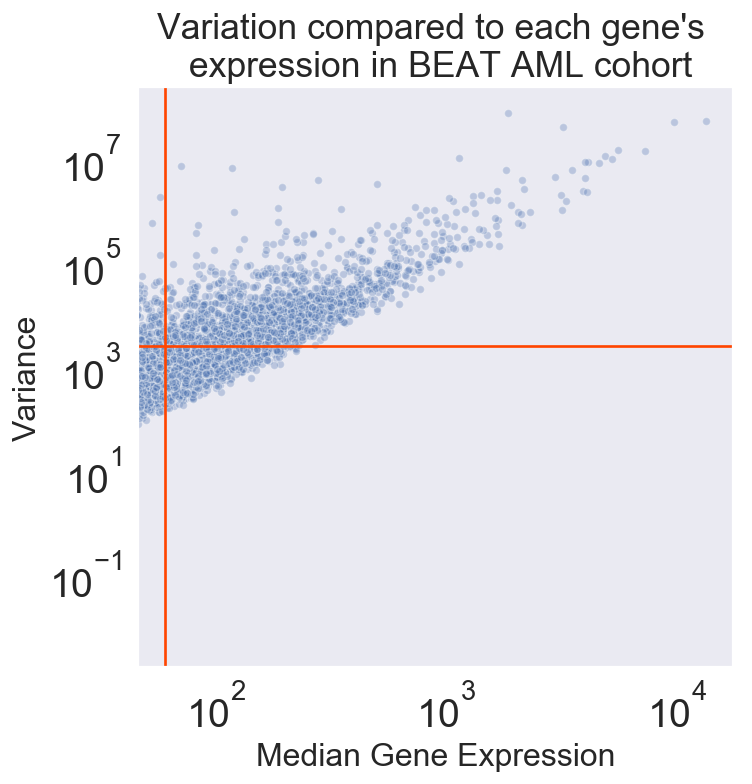

In [44]:
#Make a dataset of the median expression of each gene
med_gene_exp = Gene_Counts_CPM_edited.median(axis=0,)
med_gene_exp.sort_values(ascending=False, inplace=True)

#Plot the variance
plt.figure(dpi=128, figsize=(6, 6))
sns.scatterplot(x=med_gene_exp, y=exp_var, alpha = 0.3, s=20)
plt.title("Variation compared to each gene's \n expression in BEAT AML cohort", fontsize=20) 
plt.xlabel("Median Gene Expression", fontsize=18) 
plt.ylabel("Variance", fontsize=18)
plt.axvline(x=med_gene_exp.quantile(q=0.85), color='orangered')
plt.axhline(y=exp_var.quantile(q=0.90), color='orangered')
plt.yscale('log')
plt.xscale('log')

plt.show();

Let subset the data to only include genes that are highly expressed (Top 15%) but also highly variable (Top 15%). In otherwords, the top right section of the graph above. 

In [45]:
gene_exp_keep = med_gene_exp[med_gene_exp > med_gene_exp.quantile(q=0.85)]
var_keep = exp_var[exp_var > exp_var.quantile(q=0.85)]

Keep_col = gene_exp_keep.index.intersection(var_keep.index)

print('There are ', len(gene_exp_keep), 'values in the top 25% of genes expressed and top 25% of variance, but only', 
      len(Keep_col), 'meet both criterea.')

There are  3427 values in the top 25% of genes expressed and top 25% of variance, but only 2484 meet both criterea.


In [46]:
Gene_Counts_CPM_edited = Gene_Counts_CPM_edited.loc[:,Keep_col]

Gene_Counts_CPM_edited.shape

(451, 2484)

Out of curiousity I wanted to check if some of the genes that I study in the lab are still in the dataset. These are all genes that are involded in drug sensitivity and resistance for certain drugs, so ideally they would all still be in the dataset.

In [47]:
['FGRexp' in Keep_col,
'HCKexp' in Keep_col,
'LYNexp' in Keep_col,
'FYNexp' in Keep_col,
'FLT3exp' in Keep_col,
'SYKexp' in Keep_col,
'FESexp' in Keep_col,
'KITexp' in Keep_col]

[True, True, True, True, True, True, True, True]

Okay we now have all three datasets! Let us focus on combining the datasets.

## Cleaning Data - Combining three datasets into one large dataset

Here we want to only keep the samples (rows) that are represented in all three datasets so we will use an inner merge. We will eventually have to scale the data also

In [48]:
Clean_Data = Clinical_Summary_edited.merge(All_Variants_One_hot_encoded, how='inner', left_index=True, right_index=True)

Clean_Data = Clean_Data.merge(Gene_Counts_CPM_edited, how='inner', left_index=True, right_index=True)

print('There are ', len(Clean_Data), 'samples that are in all three datasets. The new shape of the complete dataframe is ',
      Clean_Data.shape, '.')

There are  404 samples that are in all three datasets. The new shape of the complete dataframe is  (404, 2720) .


In [49]:
Clean_Data.head()

CEBPA_Biallelic  isRelapse  isDenovo  isTransformed  \
LabId                                                           
13-00098                0          0         1              0   
13-00118                0          1         0              0   
13-00149                0          0         0              0   
13-00157                0          0         1              0   
13-00160                0          0         0              1   

          priorMalignancyNonMyeloid  cumulativeChemo  \
LabId                                                  
13-00098                          0                1   
13-00118                          0                1   
13-00149                          1                1   
13-00157                          0                1   
13-00160                          0                1   

          priorMalignancyRadiationTx  priorMDS  priorMDSMoreThanTwoMths  \
LabId                                                                     
13-00098                           0         0                        0   
13-00118                           0         0                        0   
13-00149                           0         0                        0   
13-00157                           0         0                        0   
13-00160                           0         1                        1   

          priorMDSMPN  priorMDSMPNMoreThanTwoMths  priorMPN  \
LabId                                                         
13-00098            0                         0.0         0   
13-00118            0                         0.0         0   
13-00149            0                         0.0         0   
13-00157            0                         0.0         0   
13-00160            0                         0.0         0   

          priorMPNMoreThanTwoMths  ageAtSpecimenAcquisition  \
LabId                                                         
13-00098                        0                      64.0   
13-00118                        0                      57.0   
13-00149                        0                      79.0   
13-00157                        0                      60.0   
13-00160                        0                      73.0   

          cumulativeTreatmentTypeCount  cumulativeTreatmentRegimenCount  \
LabId                                                                     
13-00098                             1                                3   
13-00118                             1                                7   
13-00149                             1                                1   
13-00157                             1                                2   
13-00160                             1                                2   

          FLT3-ITD  NPM1  consensus_sex_Female  consensus_sex_Male  \
LabId                                                                
13-00098       0.0   1.0                     1                   0   
13-00118       0.0   1.0                     0                   1   
13-00149       0.0   0.0                     0                   1   
13-00157       0.0   1.0                     1                   0   
13-00160       0.0   0.0                     0                   1   

          inferred_ethnicity_AdmixedAsian  inferred_ethnicity_AdmixedBlack  \
LabId                                                                        
13-00098                                0                                0   
13-00118                                0                                0   
13-00149                                0                                0   
13-00157                                0                                0   
13-00160                                0                                0   

          inferred_ethnicity_AdmixedHispNative  \
LabId                                            
13-00098                                     0   
13-00118                             

## Removing the Collinear Features

We now have to remove the features that are highly correlated with each other (Collinear Features) because this will make interpreting the model easier. If the model puts equal weight on two collinear features, we may miss the importance of both of these features when interpreting the model!

Removing Collinear features will require that we make a correlation plot, find the most correlated features and then remove one of those features.

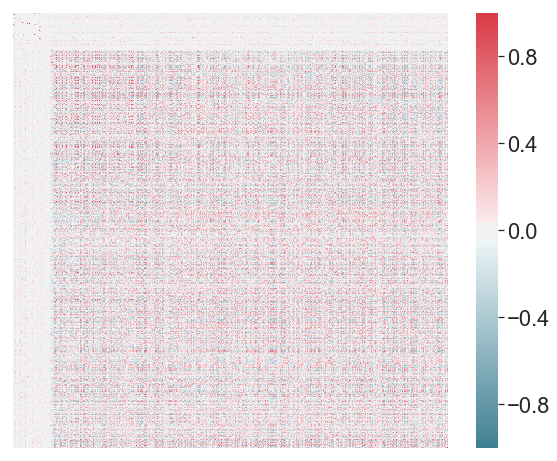

In [50]:
#Make  correlation matrix
corr = Clean_Data.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show();

Some of the variables are definitely highly positively correlated! Lets see if we can pull out the most correlated variables from this matrix.

To remove highly correlated features I borrowed some code from Chris Albon at his website. His original code can be found [here](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/).

In [51]:
# Redefine the correlation matrix to be absolute value
corr_matrix = Clean_Data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
Clean_Data.drop(to_drop, axis=1, inplace= True)

to_drop

['consensus_sex_Male',
 'specificDxAtAcquisition_AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22); CBFB-MYH11',
 'specificDxAtAcquisition_AML with t(6;9)(p23;q34); DEK-NUP214',
 'specificDxAtAcquisition_AML with t(8;21)(q22;q22); RUNX1-RUNX1T1',
 'specificDxAtAcquisition_Acute promyelocytic leukaemia with t(15;17)(q22;q12); PML-RARA',
 'specimenType_Peripheral Blood',
 'typeInductionTx_Targeted Therapy - Kinase Inhibitor(s)',
 'currentStage_CNS',
 'currentStage_NONE',
 'currentStage_Post-Transplant Relapse',
 'priorMalignancyType_y',
 'cumulativeTreatmentTypes_y',
 'cumulativeTreatmentTypesStandard Chemotherapy',
 'cumulativeTreatmentTypesUnknown',
 'cumulativeTreatmentStages_y',
 'cumulativeTreatmentStagesAllogeneic - Mismatched Unrelated Donor',
 'cumulativeTreatmentStagesInduction',
 'cumulativeTreatmentStagesIntensification',
 'cumulativeTreatmentStagesPost-Transplant Relapse',
 'MT-ND4Lexp',
 'RPL3P4exp',
 'RP11-234A1.1exp',
 'HNRNPA1P10exp',
 'RP11-889L3.1exp',
 'YBX1P1exp',
 'E

In [52]:
Clean_Data.shape

(404, 2687)

We were able to remove 33 features from our dataset. Some of these features make sense, consensus_sex_Male is likely very correlated to consensus_sex_Female. Some of them are less clear, especially the gene expression features. 

## Making sure the dataset is ready for machine learning

Firt lets make sure all of our features are type float or integer. Then lets make sure there are no null values in the dataset.

In [53]:
Clean_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 13-00098 to 16-01272
Columns: 2687 entries, CEBPA_Biallelic to AP1S2exp
dtypes: float64(2474), int32(100), int64(11), uint8(102)
memory usage: 7.9+ MB


In [54]:
Clean_Data.isnull().sum()[Clean_Data.isnull().sum() != 0]

ageAtSpecimenAcquisition    1
dtype: int64

Rather than remove the ageAtSpecimenAcquisition feature, Lets just remove the row that has a missing value.

In [55]:
Clean_Data = Clean_Data.dropna(axis = 0)

Clean_Data.shape

(403, 2687)

In [56]:
#Save the Data frame as .csv
Clean_Data.to_csv('Features.csv')

## Taking a look at the target data

Lets take a closer look at the target data and do some exploratory data analysis.

In [57]:
#Set the index so it matches the Features
Drug_Responses.rename(columns ={'lab_id':'LabId'}, inplace=True)
Drug_Responses.set_index('LabId', inplace=True)
Drug_Responses.shape

(47650, 3)

In [58]:
Drug_Responses.head()

inhibitor       ic50         auc
LabId                                                 
12-00211  17-AAG (Tanespimycin)  10.000000  225.918025
12-00219  17-AAG (Tanespimycin)   0.276661  135.264409
12-00258  17-AAG (Tanespimycin)   2.722845  164.561227
12-00262  17-AAG (Tanespimycin)   0.123136  111.555971
12-00268  17-AAG (Tanespimycin)  10.000000  226.805281

We can see that each measurement of drug sensitivity is in one row. We could make each sample one row, like we did when cleaning all of the previous datasets, but It is really each to get the subset of the data we want.

We also have two measurements of drug sensitivity. We will address this shortly. 

In [59]:
AC220 = Drug_Responses[Drug_Responses['inhibitor'].str.contains('AC220')]

AC220.head()

inhibitor      ic50         auc
LabId                                              
11-00261  Quizartinib (AC220)  0.127784  119.624652
11-00487  Quizartinib (AC220)  0.282763  135.454630
12-00023  Quizartinib (AC220)  1.475739  184.304433
12-00032  Quizartinib (AC220)  0.095106  114.848087
12-00051  Quizartinib (AC220)  0.031396  118.757663

In [60]:
AC220.shape

(450, 3)

We can see that the AC220 dataset contains 47 more rows than our features dataset. We can easily remedy this problem by doing an inner join. We will worry about this in the next notebook. 

Lets make a quick function to easily subset the portion of the drug responses dataset we want.

In [61]:
def Get_Target (dataset, compound, measurement = 'ic50'):
    Target = dataset[dataset['inhibitor'].str.contains(compound)]
    Target = Target[measurement]
    return Target
    
PKC412 = Get_Target(Drug_Responses, 'Midostaurin')
PKC412.head()

LabId
11-00261    10.000000
11-00487     1.628297
12-00023     4.279509
12-00032    10.000000
12-00051     1.919419
Name: ic50, dtype: float64

Okay we have a function to quickly subset the data we want. This will be useful in the next notebook. 

Now lets discuss the difference between IC<sub>50</sub> and AUC, and which one we should use for this project.

- An IC<sub>50</sub> value is a traditional pharmacological measurement of drug potency. IC<sub>50</sub> is a measurement of which concentration of the drug results in 50% inhibition, or in this case 50% killing of the tumor cells. IC<sub>50</sub> is useful, because it is a somewhat universal measurement. The IC<sub>50</sub> measured by researcher A, should match IC<sub>50</sub> measured by researcher B for the same tumor. To learn more about IC<sub>50</sub> I reccomend checking out [this wiki link](https://en.wikipedia.org/wiki/IC50). 

- AUC stands for area under the curve. This measurement is the amount of area underneath a concentration response curve. AUC takes into account effect size, in our case % of cells killed. Even only 10% of cells are killed by a given compound, it could still have a low IC<sub>50</sub> value, but high AUC value. For this reason AUC is probably a better single measurement of drug effect. The downside is AUC can only be compared if two assays were done the exact same way. The two researchers would have to use the same exact concentrations of drug when doing their experiments to get the same AUC. For a more detailed description of AUC [see here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3152796/).

Lets do a quick compairson of the IC<sub>50</sub> and AUC values in the AC220 dataset.

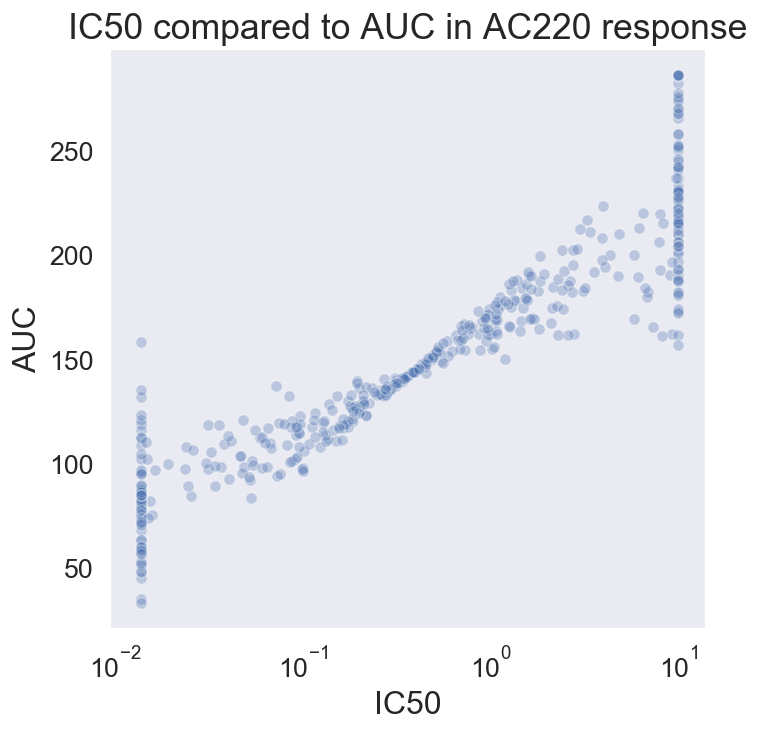

In [62]:
#set the plotting style
sns.set_style('dark')

#Make a quick scatterplot
plt.figure(dpi=128, figsize=(6, 6))
sns.scatterplot(x=AC220['ic50'], y=AC220['auc'], alpha = 0.3, s=40)
plt.title("IC50 compared to AUC in AC220 response", fontsize=20) 
plt.xlabel("IC50", fontsize=18) 
plt.ylabel("AUC", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.yscale('linear')
plt.xscale('log')

plt.show();

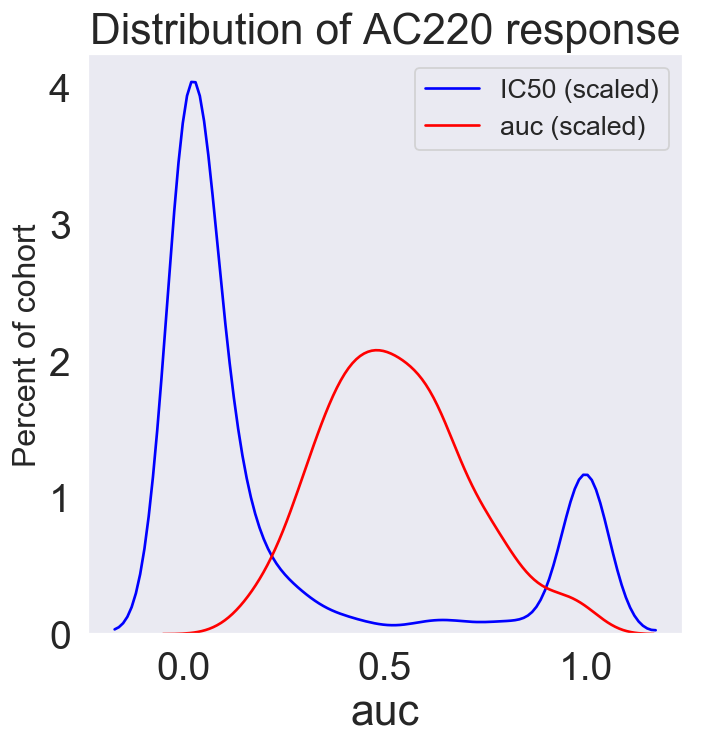

In [67]:
#Scale the IC50 and AUC data
scaled_ic50=AC220['ic50']/AC220['ic50'].max()
scaled_auc=AC220['auc']/AC220['auc'].max()

#plot the distribution of IC50 and AUC values
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(scaled_ic50, hist= False, label = 'IC50 (scaled)', color= 'blue')
sns.distplot(scaled_auc, hist= False, label = 'auc (scaled)', color = 'red')
plt.title("Distribution of AC220 response", fontsize=24) 
plt.ylabel("Percent of cohort", fontsize=18)
plt.legend(fontsize=15)

plt.show();

There appears to be somewhat of a relationship between IC<sub>50</sub> and AUC, but clearly there is also a big discrepency. AUC has more of a normal distribution while IC<sub>50</sub> can clearly be divded into responders and non-responders. 

If we wanted to use IC<sub>50</sub> as out label this will be an ideal classification problem. This actually seems like the ideal case since there is a very clear division between responders and non-responders in this dataset. Lets look at Midostaurin's response. This is another drug in the dataset, but this drug has already been approved for clinical use.

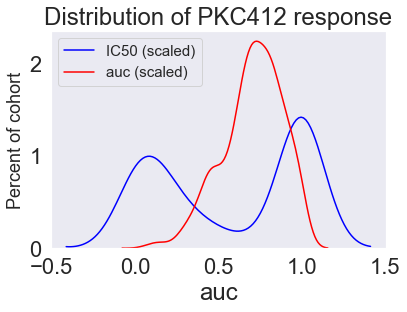

In [64]:
#Get the Midostaurin Dataset
PKC412 = Drug_Responses[Drug_Responses['inhibitor'].str.contains('Midostaurin')]

#Scale the IC50 and AUC data
scaled_ic50=PKC412['ic50']/PKC412['ic50'].max()
scaled_auc=PKC412['auc']/PKC412['auc'].max()

#plot the distribution of IC50 and AUC values
sns.distplot(scaled_ic50, hist= False, label = 'IC50 (scaled)', color= 'blue')
sns.distplot(scaled_auc, hist= False, label = 'auc (scaled)', color = 'red')
plt.title("Distribution of PKC412 response", fontsize=24) 
plt.ylabel("Percent of cohort", fontsize=18)
plt.legend(fontsize=15)

plt.show();

The distribution looks quite different, but we can easily seperate the responders from the non-responders because the distribution is bimodal. I believe all the drugs will be bimodally split which makes classification the best approach (an more likely to be accurate). 

This last plot is mainly just to satisfy my curiosity. Both Midostaurn and AC220 are Flt3 inhibitors. That specific designation doesn't matter much for this analysis overall, but I happen to study Flt3 inhibitors in my day job. If you want to learn more about Flt3 inhibitors I would check out [this review](http://mct.aacrjournals.org/content/16/6/991.long). 

If both Midostaurin and AC220 work the same way we would think that patients that respond well to one of these compounds would also respond well to the other. Lets find out if Midotauring and AC220 drug response is correlated.

<Figure size 768x768 with 0 Axes>

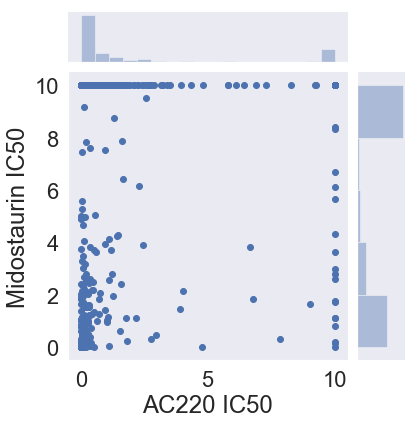

In [65]:
#Join the Mido IC50 and AC220 IC50 datasets
combined = AC220.merge(PKC412, how= 'inner', left_index=True, right_index=True)
combined.rename(columns={'ic50_x':'AC220 IC50', 'ic50_y':'Midostaurin IC50'},inplace=True)

#Make a quick scatterplot
plt.figure(dpi=128, figsize=(6, 6))
sns.jointplot(x='AC220 IC50', y='Midostaurin IC50', data= combined, kind = 'scatter')
#plt.title("IC50 comparison", fontsize=20) 
#plt.xlabel("AC220 IC50", fontsize=18) 
#plt.ylabel("Midostaurin IC50", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.yscale('linear')
plt.xscale('linear')

plt.show();

It looks like these are not correlated at all! What a surprise! This likely means that patients who don't respond to one FLt3 inhibitor may just need to try another Flt3 inhibtor. 

Let save the dataset and recap.

In [66]:
#Save the Data frame as .csv
Drug_Responses.to_csv('Targets.csv')

## Recap

In this notebook we obtained data from the recent publication from the BEAT AML project. This project tested many drugs against many AML tumor biopsies. We are hoping to use this dataset to make a model to classify drug responder and non-responders based on clinical information.

Specifically today we cleaned three dataset which contained our features. These datasets were:
1. Clinical_Summary : contained clinical information about disease progression, treatment, age, ethnicity, etc. about the patient. The majority of these features became on-hot encoded.
2. All_Variants : contained all the mutations in each tumor. We got rid of the majority of these mutations because they only occured in a small portion of dataset. These mutations became on hot encdoded features. 
3. Gene_Counts_CPM : contained gene expression of each tumor. We again got rid of most of these genes because they either had no variance (and therefore can't be used to predict anything) oor they had very low expression.

We then removed some collinear features, to help with interpretability of the model. We ended up with a dataset that is completely numeric. This data set still contains many more features than samples. 

We also did some exploratory analysis of some of the drug response data, which became our Target dataset. We will generate multiple models to predict many different drug responses, which is why I did not combine this dataset with the other three. We found that the distribution of drug responses for two drugs were bimodal, and therefore it would be very easy to make an accurate classfier. 

**Next time:** We will make a machine learning model to predict drug response to AC220. We will then interpret that model. The workflow we develop can help us quickly make models to predict drug response to all the other drugs tested in the BEAT AML project. 